In [1]:
import matplotlib.pyplot as plt

import ARESlatticeStage3v1_9 as ares
import cheetah

### Loading the lattice

The lattice is available in Ocelot's format, so we use the `from_ocelot` class method of `Segement`. Because we only care about the Experimental Area (EA), we then select a subcell of the lattice file of the entire ARES accelerator.

Unlike Cheetah, Ocelot does not support screens. Therefore, when Oceloet `Marker`s have the substiring `"screen"` in their name, Cheetah creates a `Screen` element with default properties and emits a warning about this. We can than manually set the correct screen properties.

In [2]:
segment = cheetah.Segment.from_ocelot(ares.cell, warnings=False, device="cuda").subcell("AREASOLA1", "AREABSCR1")

# Manually set screen properties
segment.AREABSCR1.resolution = (2448, 2040)
segment.AREABSCR1.pixel_size = (3.3198e-6, 2.4469e-6)

# Set some values on the magnets
segment.AREAMQZM1.k1 = 10.0
segment.AREAMQZM2.k1 = -9.0
segment.AREAMCVM1.angle = 1e-3
segment.AREAMQZM3.k1 = -8.0
segment.AREAMCHM1.angle = -2e-3

segment

Segment([Drift(length=0.00, name="AREASOLA1"), Drift(length=0.18, name="Drift_AREASOLA1"), Quadrupole(length=0.12, k1=10.0, misalignment=(0, 0), name="AREAMQZM1"), Drift(length=0.43, name="Drift_AREAMQZM1"), Quadrupole(length=0.12, k1=-9.0, misalignment=(0, 0), name="AREAMQZM2"), Drift(length=0.20, name="Drift_AREAMQZM2"), VerticalCorrector(length=0.02, angle=0.001, name="AREAMCVM1"), Drift(length=0.20, name="Drift_AREAMCVM1"), Quadrupole(length=0.12, k1=-8.0, misalignment=(0, 0), name="AREAMQZM3"), Drift(length=0.18, name="Drift_AREAMQZM3"), HorizontalCorrector(length=0.02, angle=-0.002, name="AREAMCHM1"), Drift(length=0.45, name="Drift_AREAMCHM1"), Screen(resolution=(2448, 2040), pixel_size=(3.3198e-06, 2.4469e-06), binning=1, misalignment=(0, 0), name="AREABSCR1")])

### Load particle distribution

We load the beam both as a `ParticleBeam` because only full particle tracking can take advantage of a GPU.

In [4]:
particle_beam = cheetah.ParticleBeam.from_astra("ACHIP_EA1_2021.1351.001", device="cuda")
particle_beam

ParticleBeam(n=100000, mu_x=0.000001, mu_xp=0.000000, mu_y=-0.000002, mu_yp=-0.000000, sigma_x=0.000175, sigma_xp=0.000004, sigma_y=0.000175, sigma_yp=0.000004, sigma_s=0.000008, sigma_p=0.002280, energy=107315902.444)

### Benchmark
We first start with a simple benchmark just tracking particles.

#### Particle Beam

In [11]:
segment.AREABSCR1.is_active = False

In [12]:
%%timeit
outgoing = segment(particle_beam)

737 µs ± 96.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
outgoing = segment(particle_beam)
outgoing

ParticleBeam(n=100000, mu_x=-0.000900, mu_xp=-0.002001, mu_y=0.000796, mu_yp=0.000749, sigma_x=0.000117, sigma_xp=0.000148, sigma_y=0.000009, sigma_yp=0.000332, sigma_s=0.000008, sigma_p=0.002280, energy=107315902.444)

We continue with a benchmark tracking particles and then reading the screen.

In [14]:
segment.AREABSCR1.is_active = True

In [16]:
%%timeit
outgoing = segment(particle_beam)
img = segment.AREABSCR1.reading

55.1 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


I'm an empty beam!


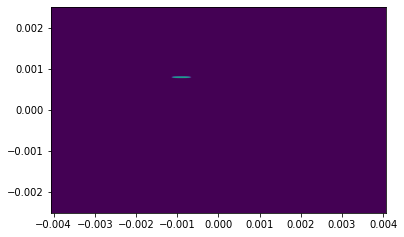

In [17]:
outgoing = segment(particle_beam)
img = segment.AREABSCR1.reading

print(outgoing) # Should be an empty beam because it is blocked by the screen

plt.imshow(img, extent=segment.AREABSCR1.extent)
plt.show()